(21310, 12)
(21310, 12)
(4307, 12)
Done. Outputs in: \mnt\data\getaround_outputs


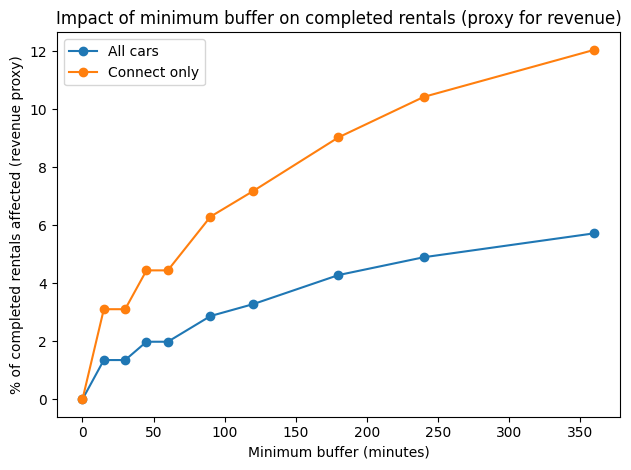

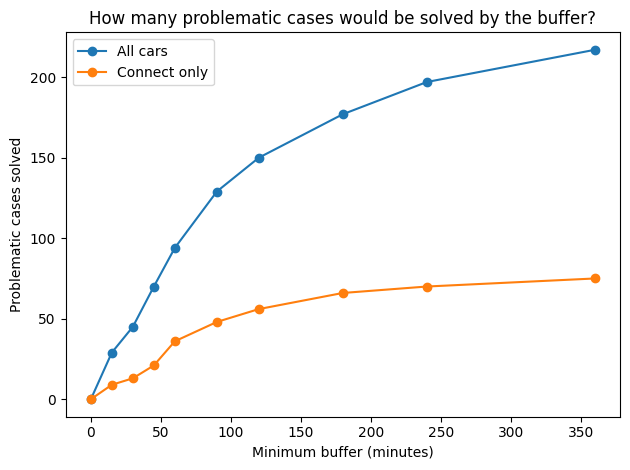

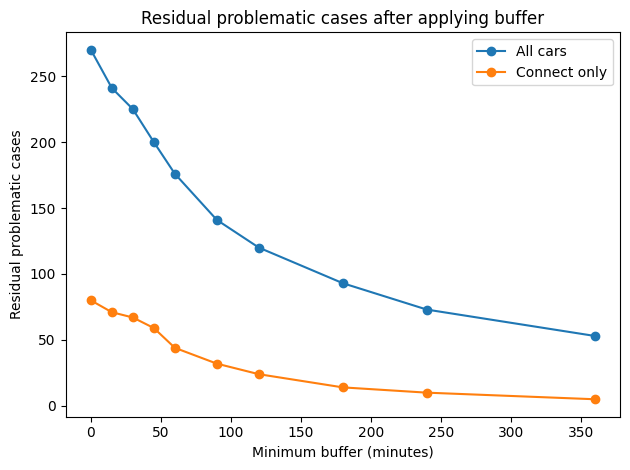

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ---------- 1) Load ----------
PATH = "../data/get_around_delay_analysis.xlsx"
df_raw = pd.read_excel(PATH, sheet_name="rentals_data")

# ---------- 2) Cleaning & features ----------
df = df_raw.copy()
df["has_previous"] = df["previous_ended_rental_id"].notna()
df["late_minutes"] = df["delay_at_checkout_in_minutes"].clip(lower=0).fillna(0)
df["gap_minutes"] = df["time_delta_with_previous_rental_in_minutes"].fillna(np.inf)
df["problematic_to_next_driver"] = (df["late_minutes"] > df["gap_minutes"]) & df["has_previous"]
df["is_completed"] = df["state"].eq("ended")
print(df.shape)
def scope_mask(scope: str):
    s = scope.lower()
    if s == "connect":
        return df["checkin_type"].str.lower().eq("connect")
    elif s == "mobile":
        return df["checkin_type"].str.lower().eq("mobile")
    else:
        return pd.Series(True, index=df.index)

def evaluate_thresholds(thresholds, scope="all"):
    m = scope_mask(scope)
    base = df[m].copy()

    total = len(base)
    completed = int(base["is_completed"].sum())

    rows = []
    for T in thresholds:
        affected = ((base["gap_minutes"] < T) & base["has_previous"]).sum()

        affected_completed = ((base["gap_minutes"] < T) &
                              base["has_previous"] &
                              base["is_completed"]).sum()
        
        share_completed_affected = (affected_completed / completed) if completed else np.nan

        problematic_now = base["problematic_to_next_driver"].sum()
        solved = ((base["problematic_to_next_driver"]) &
                  (T >= base["late_minutes"])).sum()
        residual = ((base["problematic_to_next_driver"]) &
                    (base["late_minutes"] > T)).sum()

        rows.append({
            "threshold_min": int(T),
            "scope": scope,
            "rentals_total": int(total),
            "completed_total": int(completed),
            "rentals_affected_by_buffer": int(affected),
            "completed_rentals_affected": int(affected_completed),
            "share_completed_rental_revenue_proxy_affected": float(share_completed_affected),
            "problematic_cases_now": int(problematic_now),
            "problematic_cases_solved_by_buffer": int(solved),
            "residual_problematic_after_buffer": int(residual),
        })

    return pd.DataFrame(rows).sort_values("threshold_min")

# ---------- 3) Run scenarios ----------
thresholds = [0, 15, 30, 45, 60, 90, 120, 180, 240, 360]
res_all = evaluate_thresholds(thresholds, scope="all")
res_connect = evaluate_thresholds(thresholds, scope="connect")

# ---------- 4) Save tables ----------
OUT = Path("/mnt/data/getaround_outputs")
OUT.mkdir(parents=True, exist_ok=True)
res_all.to_csv(OUT / "buffer_tradeoffs_all.csv", index=False)
res_connect.to_csv(OUT / "buffer_tradeoffs_connect.csv", index=False)

# ---------- 5) Plots ----------
plt.figure()
plt.plot(res_all["threshold_min"], 100*res_all["share_completed_rental_revenue_proxy_affected"], marker="o", label="All cars")
plt.plot(res_connect["threshold_min"], 100*res_connect["share_completed_rental_revenue_proxy_affected"], marker="o", label="Connect only")
plt.xlabel("Minimum buffer (minutes)")
plt.ylabel("% of completed rentals affected (revenue proxy)")
plt.title("Impact of minimum buffer on completed rentals (proxy for revenue)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT / "pct_completed_affected.png", dpi=160)

plt.figure()
plt.plot(res_all["threshold_min"], res_all["problematic_cases_solved_by_buffer"], marker="o", label="All cars")
plt.plot(res_connect["threshold_min"], res_connect["problematic_cases_solved_by_buffer"], marker="o", label="Connect only")
plt.xlabel("Minimum buffer (minutes)")
plt.ylabel("Problematic cases solved")
plt.title("How many problematic cases would be solved by the buffer?")
plt.legend()
plt.tight_layout()
plt.savefig(OUT / "problematic_solved.png", dpi=160)

plt.figure()
plt.plot(res_all["threshold_min"], res_all["residual_problematic_after_buffer"], marker="o", label="All cars")
plt.plot(res_connect["threshold_min"], res_connect["residual_problematic_after_buffer"], marker="o", label="Connect only")
plt.xlabel("Minimum buffer (minutes)")
plt.ylabel("Residual problematic cases")
plt.title("Residual problematic cases after applying buffer")
plt.legend()
plt.tight_layout()
plt.savefig(OUT / "residual_problematic.png", dpi=160)

# ---------- 6) One-shot answers to the questions ----------
# Q3: How often are drivers late for the next check-in? (rate + impact distribution)
base_pairs = df[df["has_previous"]].copy()
problematic_rate = float((base_pairs["late_minutes"] > base_pairs["gap_minutes"]).mean())
base_pairs["next_driver_wait_minutes"] = (base_pairs["late_minutes"] - base_pairs["gap_minutes"]).clip(lower=0)
impact_stats = base_pairs["next_driver_wait_minutes"].describe(percentiles=[.5,.75,.9,.95]).to_dict()

with open(OUT / "summary.json", "w") as f:
    json.dump({
        "problematic_rate_all_pairs": problematic_rate,
        "next_driver_wait_minutes_stats": impact_stats
    }, f, indent=2)

print("Done. Outputs in:", str(OUT))